<a href="https://colab.research.google.com/github/sims-smis/Convolutional-Neural-Network-Project/blob/main/CNN_Hyperparam_tuning_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from keras import layers

In [1]:
(train_images, train_labels), (test_images, test_labels)=keras.datasets.fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def get_class_name(label):
    return class_names[label]
get_class_name(train_labels[0])

train_images=np.expand_dims(train_images,axis=-1)
test_images=np.expand_dims(test_images,axis=-1)
train_images.shape,test_images.shape

train_images=train_images/255
test_images=test_images/255


In [ ]:
def build_model(hp):
    model = keras.Sequential()

    hp_layer1 = hp.Int('conv_1_filter', min_value=32, max_value=128, step=16)
    hp_kernel1 = hp.Choice('conv_1_kernel', values=[3, 5])
    activation_conv1 = hp.Choice('activation_conv1', values=['relu', 'tanh'])
    model.add(layers.Conv2D(filters=hp_layer1, kernel_size=hp_kernel1, activation=activation_conv1, input_shape=(28, 28, 1)))

    hp_layer2 = hp.Int('conv_2_filter', min_value=32, max_value=64, step=16)
    hp_kernel2 = hp.Choice('conv_2_kernel', values=[3, 5])
    model.add(layers.Conv2D(filters=hp_layer2, kernel_size=hp_kernel2, activation='relu'))

    model.add(layers.Flatten())

    hp_units = hp.Int('dense_1_units', min_value=32, max_value=128, step=16)
    model.add(layers.Dense(units=hp_units, activation='relu'))

    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [2]:
tuner_search=RandomSearch(build_model,
                          objective='val_accuracy',
                          max_trials=5,directory='c',project_name="Mnist Fashion")
tuner_search.search(train_images,train_labels,epochs=3,validation_split=0.1)
tunedmodel=tuner_search.get_best_models(num_models=1)[0]
tunedmodel.summary()

In [ ]:
best_hp = tuner_search.get_best_hyperparameters(num_trials=1)
best_hp[0].values

{'conv_1_filter': 128,
 'conv_1_kernel': 3,
 'activation_conv1': 'relu',
 'conv_2_filter': 64,
 'conv_2_kernel': 5,
 'dense_1_units': 112,
 'learning_rate': 0.001}

In [7]:
history = tunedmodel.fit(train_images, train_labels, epochs=10, validation_split=0.1, initial_epoch=3)

In [3]:
tunedmodel.evaluate(test_images,test_labels)

313/313 [==============================] - 1s 2ms/step


Text(170.72222222222223, 0.5, 'Truth')

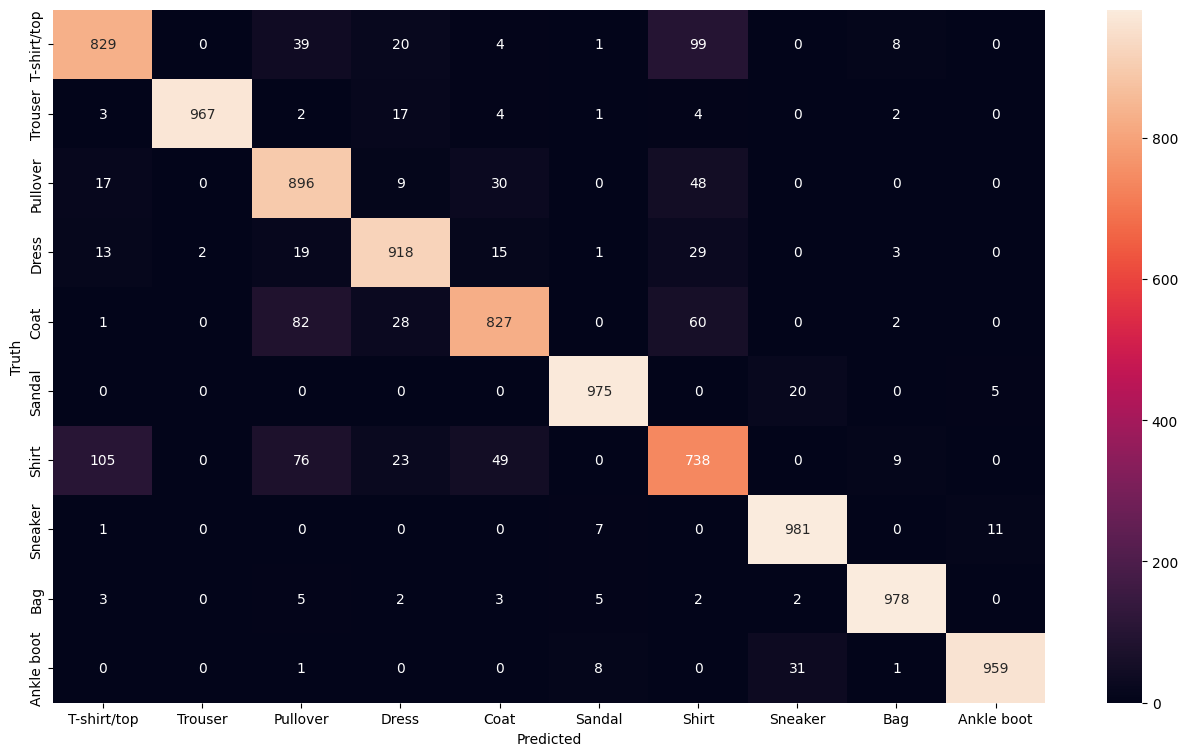

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred=tunedmodel.predict(test_images)

plt.figure(figsize=(16,9))
y_pred_labels = [ np.argmax(label) for label in y_pred ]
cm = confusion_matrix(test_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d',xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [4]:
from sklearn.metrics import classification_report
cr= classification_report(test_labels, y_pred_labels, target_names=class_names)
print(cr)

In [5]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('model accuracy');
plt.ylabel('accuracy');
plt.xlabel('epoch');
plt.legend(['Train', 'Validation']);
plt.ylim(0.8,1)

In [6]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('model loss');
plt.ylabel('loss');
plt.xlabel('epoch');
plt.legend(['Train', 'Validation']);
plt.ylim(0,4);